Importing libraries

In [1]:
#introducing libraries
#!pip install numpy scipy pandas>1.0 matplotlib lmfit colour
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel
import statistics
from matplotlib.collections import LineCollection 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.signal import argrelmax
#import CSV data from drive
#from google.colab import drive
import glob
import os
#drive.mount('drive', force_remount=True)
folder = "C:/Users/Daniel/Desktop/Programming/PBDBT-ITIC data/Pre-processed data"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace(folder+'\\',"")
  #import data
  df = pd.read_csv(filename, sep=',', header=0)

  #Some cleaning
  df.drop(df.tail(14).index, inplace=True)
  df = df.rename({'0.00000E+0.1':'0.000000000'}, axis=1)
  cols = df.columns.values
  cols[0] = 'Wavelength(nm)'
  df.columns = cols
  df = df.set_index('Wavelength(nm)')
  #remove rows (wavelengths) with at least 3 na values
  df = df.dropna(axis=0, thresh=3)

  #change strings to numbers
  df = df.astype(float)
  #df['Energy(eV)'] = 1239.842/df.index.astype(float)
  #df = df.set_index('Energy(eV)')
  df.columns = np.around(pd.to_numeric(df.columns), 2)
  df.index = np.around(pd.to_numeric(df.index),2)

  titles.append(new_name)
  Spec_data[new_name] = df

Spec_data



{'01 CB blend 1mW magic angle -5--4000ps -bg -t0':                 -4.83     -4.58         -4.33     -4.08     -3.83     \
 Wavelength(nm)                                                         
 814.50          0.000090 -0.000008  3.228720e-05  0.000082  0.000052   
 817.93         -0.000067 -0.000091  3.480710e-05  0.000033  0.000032   
 821.35         -0.000088 -0.000113  7.494070e-05 -0.000015 -0.000004   
 824.77         -0.000044 -0.000054  8.701310e-05 -0.000042 -0.000004   
 828.20         -0.000096 -0.000021  4.343670e-05  0.000003  0.000018   
 ...                  ...       ...           ...       ...       ...   
 1339.19         0.000011 -0.000021  3.686230e-05  0.000129 -0.000056   
 1342.68         0.000011 -0.000083  1.020540e-04  0.000041  0.000003   
 1346.16         0.000072 -0.000019  6.041390e-05  0.000065  0.000010   
 1349.64         0.000052 -0.000032 -5.020700e-07  0.000017  0.000034   
 1353.13         0.000040 -0.000040  4.816940e-05  0.000025  0.000010   
 

Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

In [2]:

#REMOVE NOISY SECTIONS, ADJUST NIR AND UVVIS TO LOOK CONTINUOUS ON GRAPH
for name in Spec_data:
  if 'UvVis' in name:
    new = Spec_data[name][~((Spec_data[name].index > 400) & (Spec_data[name].index < 700))]
    print(Spec_data[name].loc[new.index, :])
    Spec_data[name].loc[new.index, :] = np.nan
    Spec_data[name] = Spec_data[name]/0.6

  else:
    print(name)
    new = Spec_data[name][~((Spec_data[name].index < 1400) & (Spec_data[name].index > 850))]
    print(Spec_data[name].loc[new.index, :])
    Spec_data[name].loc[new.index, :] = np.nan
    Spec_data[name] = Spec_data[name]*3

#remember to remove laser signal
for name in Spec_data:
  if 'UvVis' in name:
    new = Spec_data[name][((Spec_data[name].index <= 540) & (Spec_data[name].index >= 500))]
    print(Spec_data[name].loc[new.index, :])
    Spec_data[name].loc[new.index, :] = np.nan

#create new dataset
merged_data = {}
for name1 in Spec_data:
  for name2 in Spec_data:
    if (name1 != name2) & (name1[0:2] == name2[0:2]):
      comb = pd.concat([Spec_data[name1], Spec_data[name2]])
      if 'UvVis' not in name1:
        new_name = name1[0:12]
      elif 'UvVis' not in name2:
        new_name = name2[0:12]
      merged_data[new_name] = comb.sort_index()

merge_interp = {}
for name in merged_data:
  merge_interp[name] = (merged_data[name].T).interpolate().T

merge_interp

Spec_data

01 CB blend 1mW magic angle -5--4000ps -bg -t0
                    -4.83     -4.58     -4.33         -4.08     -3.83     \
Wavelength(nm)                                                             
814.50          8.959170e-05 -0.000008  0.000032  8.166630e-05  0.000052   
817.93         -6.674610e-05 -0.000091  0.000035  3.314800e-05  0.000032   
821.35         -8.769170e-05 -0.000113  0.000075 -1.473610e-05 -0.000004   
824.77         -4.396250e-05 -0.000054  0.000087 -4.204460e-05 -0.000004   
828.20         -9.643340e-05 -0.000021  0.000043  3.297680e-06  0.000018   
831.62         -6.029070e-05 -0.000057  0.000032  2.503800e-05 -0.000008   
835.04         -6.539440e-05 -0.000054  0.000035 -1.252360e-05  0.000029   
838.47         -4.873150e-07  0.000008  0.000025  2.942970e-05  0.000010   
841.89         -3.264380e-05 -0.000011 -0.000003  4.421620e-07  0.000025   
845.32         -1.451790e-05  0.000028 -0.000010  3.805920e-05  0.000021   
848.74          1.711980e-06  0.000042 -0

{'01 CB blend 1mW magic angle -5--4000ps -bg -t0':                 -4.83     -4.58     -4.33     -4.08     -3.83     -3.58     \
 Wavelength(nm)                                                               
 814.50               NaN       NaN       NaN       NaN       NaN       NaN   
 817.93               NaN       NaN       NaN       NaN       NaN       NaN   
 821.35               NaN       NaN       NaN       NaN       NaN       NaN   
 824.77               NaN       NaN       NaN       NaN       NaN       NaN   
 828.20               NaN       NaN       NaN       NaN       NaN       NaN   
 ...                  ...       ...       ...       ...       ...       ...   
 1339.19         0.000032 -0.000062  0.000111  0.000386 -0.000169 -0.000309   
 1342.68         0.000033 -0.000250  0.000306  0.000122  0.000008 -0.000285   
 1346.16         0.000217 -0.000058  0.000181  0.000194  0.000031 -0.000108   
 1349.64         0.000156 -0.000095 -0.000002  0.000051  0.000101 -0.000543   
 1

c:\ProgramData\Miniconda3\lib\site-packages\numpy\ma\core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


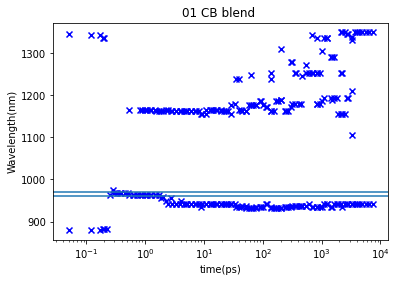

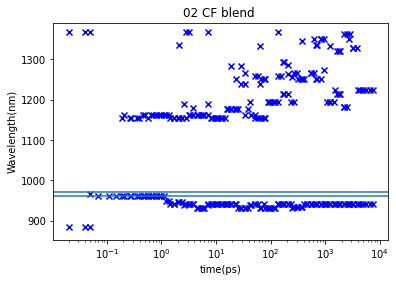

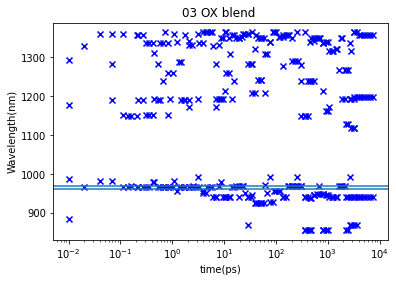

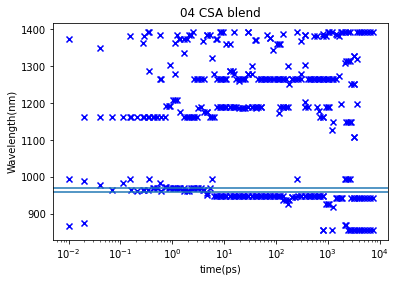

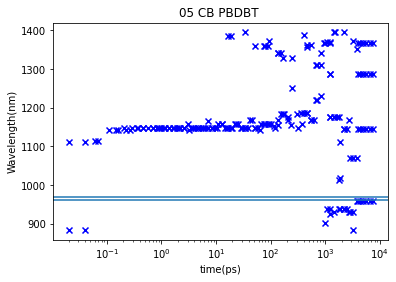

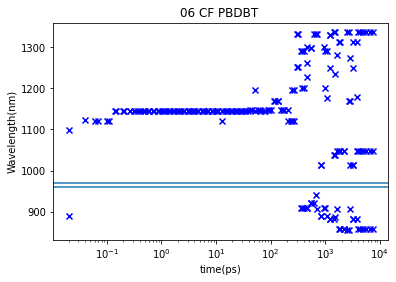

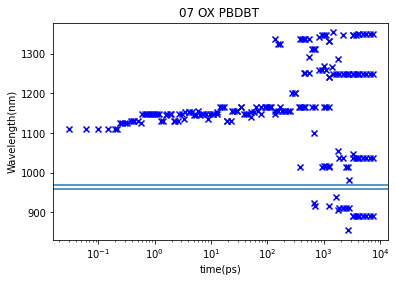

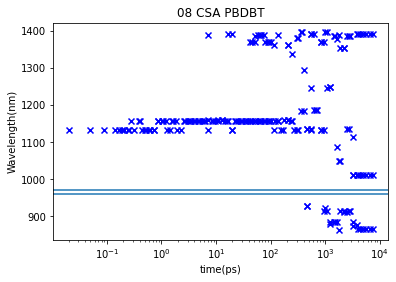

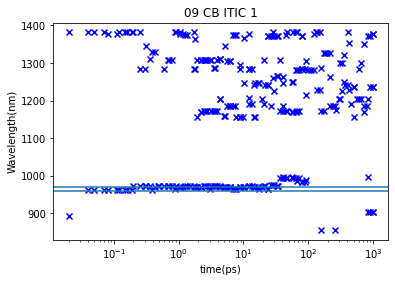

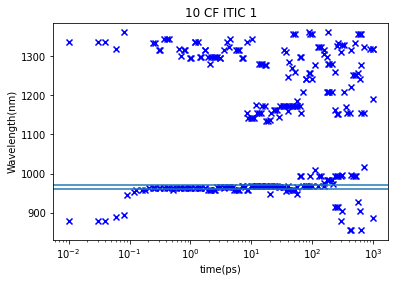

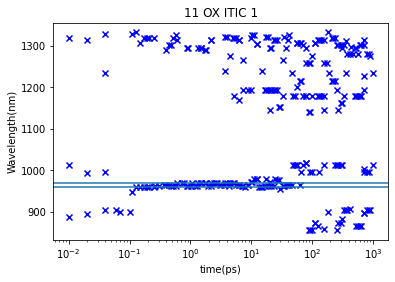

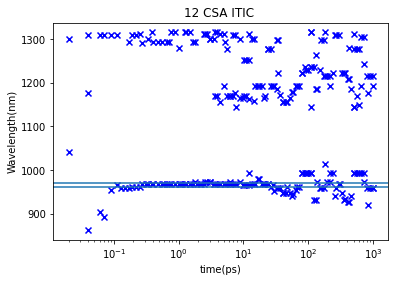

In [6]:
#cleaning
def clean_na(df):
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='all')
    return df



#SEGREGATE DATA
data_NIR = {}
data_UVVis = {}
for name in merge_interp:
    df = merge_interp[name]
    data_NIR[name] = clean_na(df[df.index>800])
    data_UVVis[name] = df[df.index<800]


#Define a color map
cmap='viridis'


def peak_coords(df, time, kind='max'):
    y = df[time]

    #prominence value based on max for time used, or over whole dataset?
    time_max = y.max() 
    df_max = df.max().max()
    #peaks, other = scipy.signal.find_peaks(y, prominence=0.05*df_max)
    #alternatively, use argrelextrema?
    n=20
    if kind=='max':
        peaks = scipy.signal.argrelextrema(np.asarray(y), np.greater, order=n)
    elif kind == 'min':
        peaks = scipy.signal.argrelextrema(np.asarray(y), np.less, order=n)
    else:
        return None, None
    x_peaks = df.iloc[peaks].index.to_list()
    y_peaks = df.iloc[peaks][time].to_list()
    return x_peaks, y_peaks

def plot_peaks(df, time):
    x_peaks, y_peaks = peak_coords(df, time, 'min')
    #may want to get use out of x_peaks info
    plt.plot(x_peaks, y_peaks, 'xb')
    #add in labels?
    for peak in x_peaks:
        plt.annotate(round(peak), xy=(peak, y_peaks[x_peaks.index(peak)]))
    plt.vlines(x_peaks, ymin=0, ymax=y_peaks)
    

#new peak function: apply peak_coords to all available times >0 for dataset to check (more continuously) for drift
def plot_peak_drift(df, cmap=cmap):
    colormap=cm.get_cmap(cmap)
    new_df = remove_times_before(df, 0)
    times = new_df.columns.to_list()
    wls = []
    color_list = [colormap(i/len(times)) for i in range(len(times))]
    for time in times:
        x_peaks, y_peaks = peak_coords(new_df, time, 'max')
        wls.append(x_peaks)
        for wl in x_peaks:
            #plt.scatter(time, wl, c=color_list[times.index(time)])
            plt.scatter(time,wl, marker='x', c='blue')
    #plt.plot(times, wls, 'xb')
    plt.gca().set_xscale('log')
    
    



for name in data_NIR:
    df = data_NIR[name]
    plot_peak_drift(df)
    plt.title(name)
    plt.xlabel('time(ps)')
    plt.ylabel('Wavelength(nm)')
    plt.axhline(960, 0, 1000)
    plt.axhline(970, 0, 1000)
    plt.show()

        

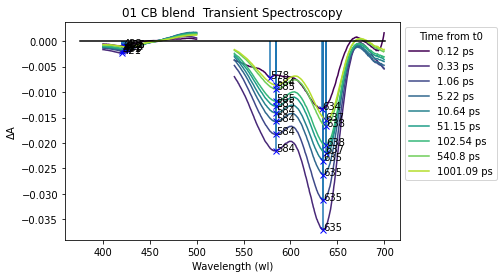

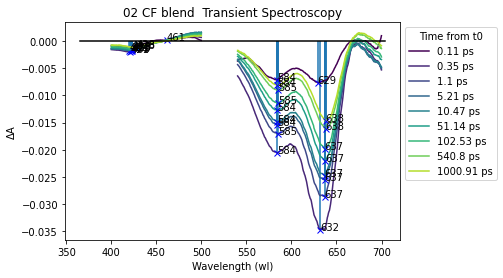

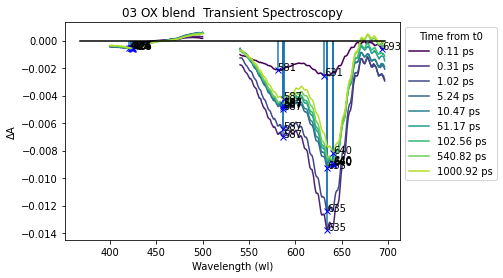

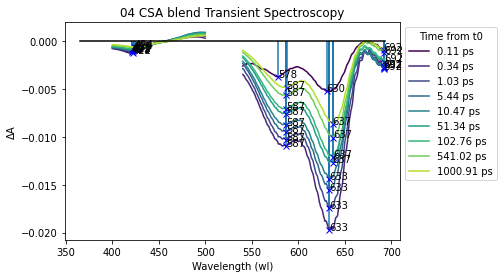

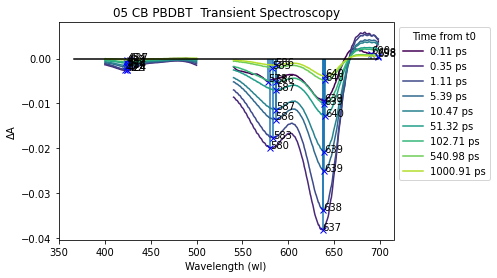

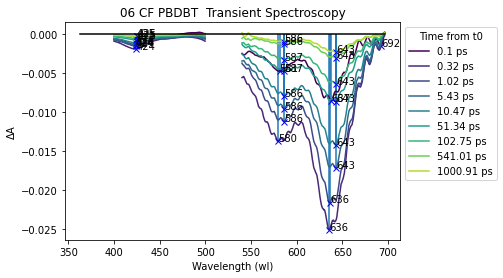

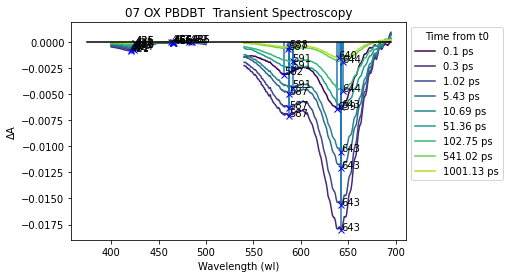

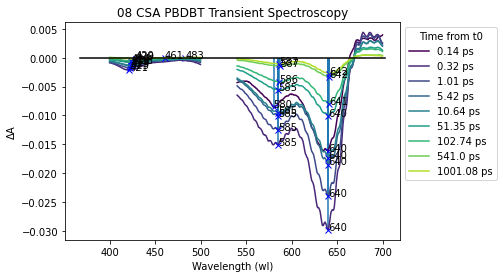

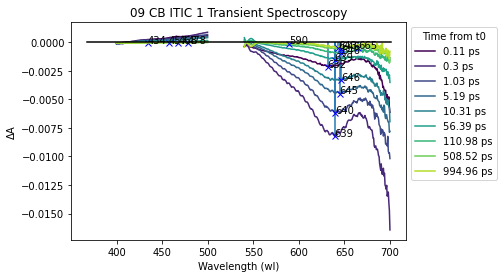

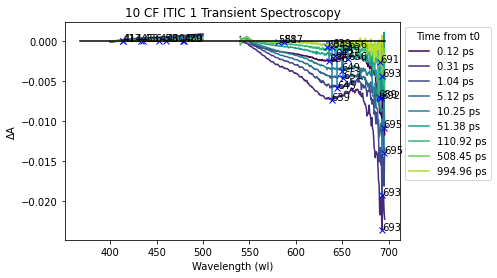

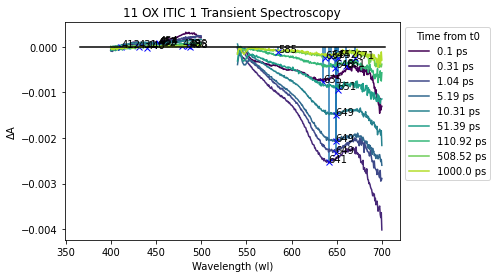

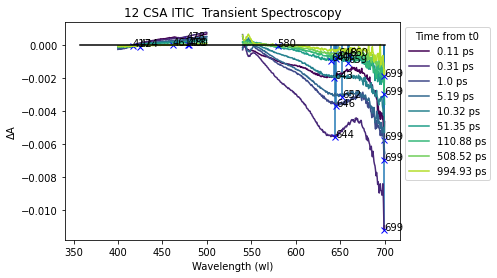

In [7]:




'''
#color method from stack exchange :https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
c1='white' 
c2='black' 
#n=len(times)
#better color method?
colormap = cm.get_cmap('viridis')
#find global maxes to fix TA scale
maxes=[]
mins=[]
bmaxes=[]
bmins=[]
pmaxes = []
pmins = []
imaxes=[]
imins=[]
for name in merge_interp:
  if int(name[0:2]) <= 4:
    bmaxes.append(merge_interp[name].max().max())
    bmins.append(merge_interp[name].min().min())
  elif int(name[0:2]) > 4 and int(name[0:2]) <= 8:
    pmaxes.append(merge_interp[name].max().max())
    pmins.append(merge_interp[name].min().min())
  elif int(name[0:2]) > 8:
    imaxes.append(merge_interp[name].max().max())
    imins.append(merge_interp[name].min().min())
  maxes.append(merge_interp[name].max().max())
  mins.append(merge_interp[name].min().min())
bmax = max(bmaxes)
bmin = min(bmins)
pmax = max(pmaxes)
pmin = min(pmins)
imax = max(imaxes)
imin = min(imins)  
gmax = max(maxes)
gmin = min(mins)
'''
#routine for switching between type comparisons
def switch(name, a, b, c):
  if int(name[0:2]) <= 4:
    return a
  elif int(name[0:2]) > 4 and int(name[0:2]) <= 8:
    return b
  elif int(name[0:2]) > 8:
    return c
#https://codereview.stackexchange.com/questions/189319/nearest-neighbor-algorithm-general-neares
def find_nearest(array, number, direction): 
    if direction is None:
        idx = (np.abs(array - number)).min()
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    return idx

#SUCH BIZARRE CODE, UPDATE: CLEANED IT!
names = [name for name in merge_interp]
#define colormap for future graphs
cmap = 'viridis'


def spec_time_data(spectrum, names=names, desired_times = [0.1, 0.3,  1, 5, 10, 50, 100, 500,950], cmap=cmap):
  colormap = cm.get_cmap(cmap)
  for name in names:
    ##use whichever dataset it belongs to (both!)
    if spectrum == 'NIR':
      df = data_NIR[name]
    elif spectrum == 'UVVis':
      df = data_UVVis[name]
    else:
      return None

    ##actual time index will find closest element to desired times
    for desired_time in desired_times:
      time = np.around(find_nearest(df.columns,desired_time, 'forward')+desired_time, 2)
      X = np.asarray(df.index)
      y =  np.asarray(df[time])

      #plots with color along the color map simply linearly following the index of desired times
      plt.plot(X,y, label=str(time)+' ps', color=colormap(desired_times.index(desired_time)/len(desired_times)))
      if time > 0.01:
        #add in peaks
        plot_peaks(df, time)



    plt.legend(title='Time from t0', bbox_to_anchor=(1,1), loc="upper left")
    plt.title(name + " Transient Spectroscopy")
    plt.xlabel('Wavelength (wl)')
    plt.ylabel('ΔA')

    #0 line?
    plt.plot(np.array(df.index),  np.zeros(len(df.index), dtype=float, order='C'), color='black')
    plt.show()

#spec_time_data('NIR')
spec_time_data('UVVis')




Continuous peak listing -- check for drift

In [8]:
def peak_list(df, min=df.min().min(), max = df.max().max()):
    for time in df.columns:
        print(time)
    pass

for name in merge_interp:
    df = data_NIR[name]
    peak_list(df)

###MAKE "DATA" CLASS

-4.83
-4.79
-4.58
-4.53
-4.33
-4.29
-4.08
-4.04
-3.83
-3.79
-3.58
-3.54
-3.33
-3.29
-3.08
-3.03
-2.83
-2.79
-2.58
-2.54
-2.33
-2.29
-2.08
-2.03
-1.83
-1.79
-1.58
-1.54
-1.33
-1.29
-1.08
-1.04
-0.83
-0.79
-0.58
-0.53
-0.33
-0.29
-0.27
-0.24
-0.22
-0.19
-0.15
-0.11
-0.08
-0.07
-0.01
0.05
0.12
0.17
0.19
0.2
0.22
0.25
0.28
0.29
0.33
0.38
0.39
0.45
0.51
0.53
0.62
0.65
0.74
0.81
0.89
0.99
1.06
1.21
1.28
1.45
1.54
1.72
1.86
2.04
2.25
2.41
2.72
2.83
3.3
3.31
3.86
4.0
4.49
4.87
5.22
5.91
6.06
7.02
7.19
8.12
8.74
9.39
10.64
10.85
12.52
12.95
14.43
15.77
16.64
19.17
19.2
22.07
23.39
25.41
28.48
29.24
33.64
34.7
38.69
42.28
44.49
51.15
51.51
58.8
62.77
67.58
76.49
77.66
89.24
93.21
102.54
113.59
117.81
135.35
138.43
155.48
168.7
178.6
205.15
205.6
235.64
250.58
270.65
305.4
310.85
357.02
372.21
410.03
453.65
470.9
540.8
552.91
621.07
673.9
713.24
819.08
821.36
940.63
1001.09
1080.19
1220.15
1240.46
1424.49
1487.15
1635.81
1812.59
1878.48
2157.14
2209.24
2477.12
2692.7
2844.56
3266.5
3281.96
3751.0

C:\Users\Daniel\AppData\Local\Temp/ipykernel_12024/2952430663.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  psm = ax.pcolormesh(data.index,np.log10(data.columns+6), data.T, cmap=cmap, rasterized=True, vmin=-0.02, vmax=0.02)


TypeError: unsupported operand type(s) for /: 'int' and 'list'

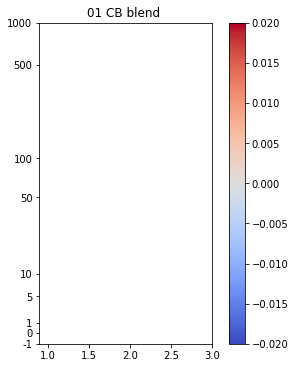

In [9]:
#method from mathplotlib documentation

viridis = cm.get_cmap('coolwarm', 100)
def plot_examples(colormaps, data, name):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 5),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data.index,np.log10(data.columns+6), data.T, cmap=cmap, rasterized=True, vmin=-0.02, vmax=0.02)
        fig.colorbar(psm, ax=ax)
        ax.title.set_text(name)
    plt.xlim(0.9,3.0)
    yvals = np.asarray([-1, 0, 1, 5, 10, 50, 100, 500, 1000])
    ylogs = np.around(np.log10(yvals + 6), 2)
    plt.ylim(ylogs[0], ylogs[-1])
    plt.yticks(ylogs, labels=yvals)
    if "ITIC" in name:
      peaks = [1.78, 1.93]
      
    elif "PBDBT" in name:
      peaks = [1.97, 2.12, 2.92]
    elif 'blend' in name:
      peaks = [1.78, 1.93,1.97, 2.12, 2.92]
    else:
      peaks=[]
    #change eV to nm
    peaks = 1240/peaks
    for eg in peaks:
      plt.axvline(eg, ls='-.', lw=1.2, c='green')

    plt.xlabel('Energy(eV)')
    plt.ylabel('Time (ps)')
for name in merged_data:
  merged_data[name] = (merged_data[name].T).interpolate().T

  plot_examples([viridis], merged_data[name], name)
  plt.show()


Kinetics

     a1     t1
0  0.56  682.7


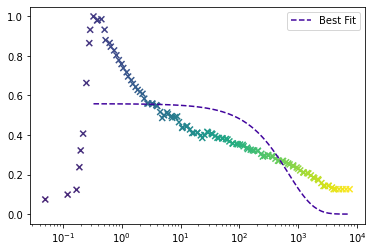

     a1     t1
0  0.55  744.7


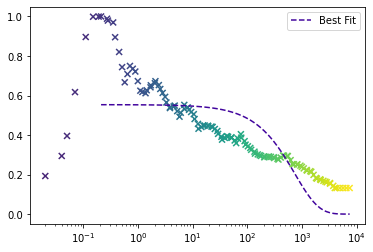

     a1      t1
0  0.41  4395.6


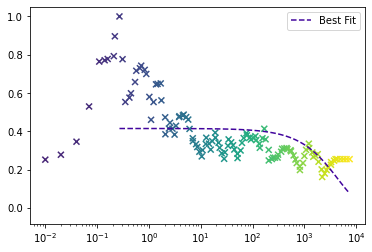

     a1      t1
0  0.47  1159.5


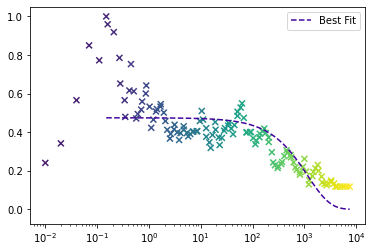

    a1    t1
0  0.7  28.8


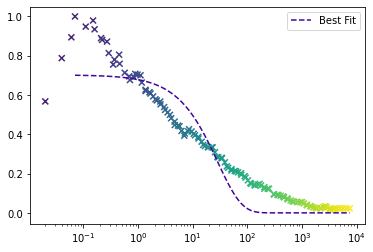

     a1    t1
0  0.77  23.5


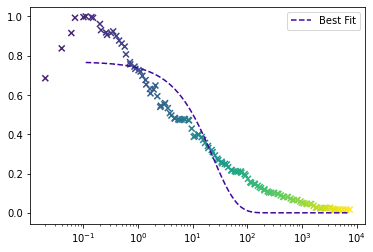

     a1    t1
0  0.74  25.2


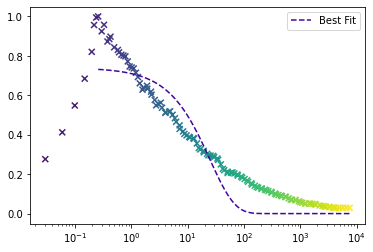

     a1    t1
0  0.63  36.1


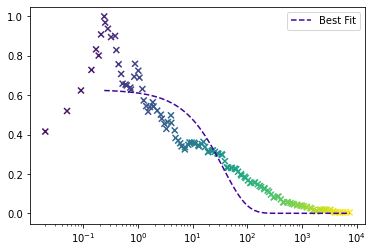

     a1   t1
0  0.94  3.3


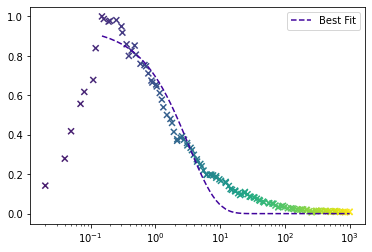

     a1   t1
0  0.85  4.7


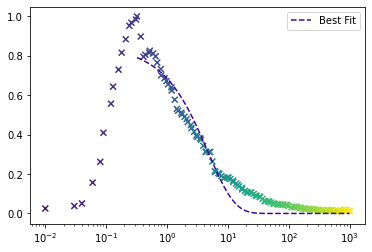

     a1   t1
0  0.89  2.7


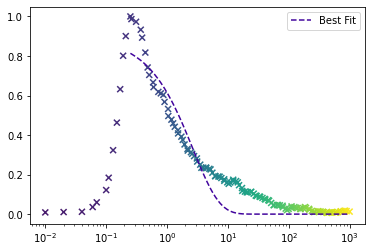

     a1   t1
0  0.85  4.1


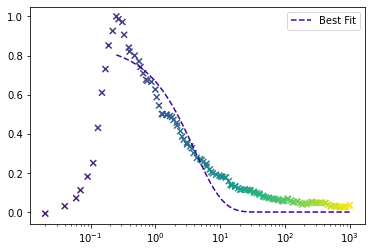

In [20]:
#add in function to remove data times < 0?
def remove_times_before(df, time):
    new_df = df.drop(df.columns[df.columns<time], axis=1)
    return new_df


#Modeling
#Kinetic algorithm
from scipy.optimize import curve_fit
from lmfit import Model, Parameter, Parameters, report_fit
from lmfit.models import ExponentialModel

def single_exp(x, a1, t1):
    return a1 * np.exp(-(x)/t1)

def double_exp(x, a1, a2, t1, t2):
  return a1*np.exp(-1*(x)/t1) + (a2)*np.exp(-1*(x)/t2)

def tri_exp(x, a1, t1, a2, t2, a3, t3):
  return a1*np.exp(-1*(x)/t1) + (a2)*np.exp(-1*(x)/t2) + (a3)*np.exp(-1*(x)/t3)

def multi_exp(order):
    model = sum([ExponentialModel() for i in range(order)])
    return model

def power_law(x,a1,t1):
  return t1/(x**a1)










class Kinetic:
    def __init__(self, dataset, wavelength, cmap = cmap):
        self.cmap = cmap
        self.wl = wavelength
        self.data = self.get_kinetics(dataset, wavelength)
        pass
        
    def get_kinetics(self, df, wl):
        k_df = pd.DataFrame()
        df = remove_times_before(df, -1)
        try:
            k_df = df.loc[wl]
        except:
            k_df = df.loc[wl-find_nearest(df.index,wl, None)]
        return k_df


    def graph_without_show(self, cmap=cmap, model=None):
        k_df = self.data
        #coloring it similarly to spectra
        colormap = cm.get_cmap(cmap)
        #overdoing it?
        #color_list = [colormap(time/len(k_df)) for time in k_df.index.tolist()]
        color_list = [colormap(i/len(k_df)) for i in range(len(k_df))]
        plt.scatter(k_df.index, k_df, marker='x', color=color_list)
        plt.gca().set_xscale('log')
        plt.set_cmap(cmap)
        '''
        #trying to put together continuous color line
        segs = [[wl]+[float(k_df.loc[wl])] for wl in k_df.index]
        line_segs = LineCollection(segs)
        print(line_segs)
        '''
        
    def graph(self):
        self.graph_without_show()
        plt.show()

    def normalize(self):
        self.data = self.data/self.data.max()

    def model_kinetics(self, model):

        #find time of peak
        tmax = x[pd.DataFrame(y).idxmax()]
        x_fit = x[x>=tmax]
        y_fit = y[x>=tmax]
        model = Model(func, independent_vars=['x'])
        params = Parameters()
        params.add('a1', value=0.5, min=-1, max=1)
        params.add('t1', value=5, min=0, max=700000)


        result = model.fit(y_fit, params, x=x_fit)

  

        a1 = np.around(result.values['a1'], 2)

        t1 = np.around(result.values['t1'], 1)



        df = pd.DataFrame(data={'a1':a1, 't1':t1}, index=[0])
        print(df)

        plt.plot(x_fit, result.best_fit, '--', color=colormap(i/10), label='Best Fit')
        plt.legend(loc='best')
        return result

    def k_fit(self, func, name=name):
        #find time of peak
        tmax = self.data.idxmax()
        x = self.data.index
        y = self.data
        x_fit = x[x>=tmax]
        y_fit = y[x>=tmax]
        model = Model(func, independent_vars=['x'])
        params = Parameters()
        params.add('a1', value=0.5, min=-1, max=1)
        params.add('t1', value=5, min=0, max=700000)


        result = model.fit(y_fit, params, x=x_fit)

  

        a1 = np.around(result.values['a1'], 2)

        t1 = np.around(result.values['t1'], 1)



        df = pd.DataFrame(data={'a1':a1, 't1':t1}, index=[0])
        print(df)

        plt.plot(x_fit, result.best_fit, '--', color=colormap(1/10), label='Best Fit')
        plt.legend(loc='best')
        return result
        

#Is there an easier way to call up all the data and still execute different desired functions
for name in data_NIR:
    df = data_NIR[name]
    obj = Kinetic(df, 936)
    obj.normalize()
    obj.graph_without_show()
    obj.k_fit(single_exp)
    plt.show()







WLs_of_interest = [450, 590, 610, 660, 700, 750, 930, 1000, 1200,1250, 1300]
WL_UV = sorted(i for i in WLs_of_interest if i <= 800)
WL_NIR = sorted(i for i in WLs_of_interest if i > 800)

def find_nearest_dex(array, number, direction=None): 
    idx = -1
    if direction is None:
        ser = np.abs(array-number)
        idx = ser.get_loc(ser.min())
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta.get_loc((_delta_positive.min()))
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta.get_loc(_delta_positive.min())
    return idx
colormap = cm.get_cmap('plasma')
styles = [':', '--', '-.', (0, (3, 5, 1, 5)), (0, (1, 10)), (0, (1, 1)), (0, (3, 10, 1, 10, 1, 10)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (5, 5)),(0, (3, 1, 1, 1)),  (0, (1, 1))]
def k_chart(data, name, guess, func):

  dex = find_nearest_dex(data.index, guess)
  region = ''
  if guess > 800:
    region = 'NIR'
  elif guess <= 800:
    region = 'UV-Vis'
  #dd = data.iloc[dex-10:dex+10].mean()
  #data2 = dd[dd.index>1]
  #data3 = dd[(dd.index>1) & (dd.index<10)]
  #data4 = dd[(dd.index>400) & (dd.index<4500)]
  #update = pd.DataFrame(data4, columns = ['vals'])
  #slope = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[0]
  #intercept = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[1]
  #stderr = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[4]
  #update['estimate'] = 10**(slope*update.index+intercept)
  #+" -- Slope: "+str(np.around(slope, 6))+ " Std Err: "+str(np.around(stderr,8))

  
  
  i = WLs.index(guess)
  label = str(guess)+' nm'

  peak_to_norm =  data.iloc[dex-10:dex+10].mean().max()
  trough_to_norm = data.iloc[dex-10:dex+10].mean().min()
  norm = max(abs(peak_to_norm), abs(trough_to_norm))
  x = np.asarray(data.columns)

  y = abs(np.asarray(data.iloc[dex-10:dex+10].mean())/norm)
  tmax = x[pd.DataFrame(y).idxmax()]
  x=x-tmax
  y=y[x>7]
  x=x[x>7]
  plt.scatter(x,y, label=label)
  #plt.plot(np.asarray(update.index), np.asarray(update['estimate']), linewidth=0.8, color='black')

  k_fit(x, y, power_law, name)
  
  plt.ylabel('ΔA (normalized)')
  plt.yscale('log')
  plt.xscale('symlog')
  plt.ylim(0.01,1.2)
  plt.xlim(0,6000)
  plt.xlabel('Time (ps)')








def k_chart_bk(data, guess, label):
  f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

  # plot the same data on both axes
  ax.plot(x, y)
  ax2.plot(x, y)

  ax.set_xlim(0,7.5)
  ax2.set_xlim(40,42.5)

  # hide the spines between ax and ax2
  ax.spines['right'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax.yaxis.tick_left()
  ax.tick_params(labelright='off')
  ax2.yaxis.tick_right()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

  d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
  kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
  ax.plot((1-d,1+d), (-d,+d), **kwargs)
  ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

  kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
  ax2.plot((-d,+d), (1-d,1+d), **kwargs)
  ax2.plot((-d,+d), (-d,+d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'


for name in Spec_data:
  if 'UV-Vis' in name:
    WLs = WL_UV
  elif 'NIR' in name:
    WLs = WL_NIR
    k_chart(Spec_data[name], name, 1250, tri_exp)
    title  = name + ': ' +str(np.around(fluence_translate(name), 1))+' uJ/pulse/cm^2'
    plt.title(title)
    plt.legend()
    plt.show()
